# **Programa Especializado en Credit Scoring con Python**
<img src="../../figuras/logo.png" width="200"/>

## 📊 **Sesión 4: Transformación de Variables, Weight of Evidence (WOE) e Information Value (IV).**

**Docente**: Enzo Infantes Zúñiga  
**Contacto**: <enzo.infantes28@gmail.com>  
**LinkedIn**: [enzo-infantes](https://www.linkedin.com/in/enzo-infantes/)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

import os

absolute_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(absolute_path, "data", "s04")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.4f}'.format)

## 🎯 **Objetivos de la sesión**

Al finalizar esta clase el participante será capaz de:


1. Por qué transformar variables en Credit Scoring.
    1.1 Credit Score FOCI
2. Qué es exactamente el Weight of Evidence (WOE).
3. Cómo se deriva matemáticamente.
4. Qué mide el Information Value (IV).
5. Cómo aplicarlo correctamente.
6. Cómo interpretar los resultados económicamente.

## 📊 **0. Dataset**

El dataset contiene información detallada sobre el perfil crediticio de individuos, incluyendo variables sociodemográficas, de comportamiento financiero y características de sus productos crediticios. Estas variables son fundamentales para evaluar la solvencia, comportamiento de pago y segmentación crediticia mediante modelos de *credit scoring*.

### 🛠️ **Especificación de Variables**

| N° | Variable | Descripción | Categoría |
|:---:|:---|:---|:---:|
| **1** | `Age` | Edad del individuo en años. | 👤 |
| **2** | `Gender` | Género del individuo. | 🚻 |
| **3** | `Marital Status` | Estado civil del individuo. | 💍 |
| **4** | `Education Level` | Máximo nivel educativo alcanzado. | 🎓 |
| **5** | `Employment Status` | Situación laboral actual del individuo. | 💼 |
| **6** | `Credit Utilization Ratio` | Proporción del crédito utilizado respecto al límite total disponible. | 📊 |
| **7** | `Payment History` | Historial de pagos mensuales: pagos a tiempo, retrasos, impagos o defaults. | 📅 |
| **8** | `Number of Credit Accounts` | Número total de cuentas de crédito activas. | 🧾 |
| **9** | `Loan Amount` | Monto total del préstamo otorgado o solicitado. | 💵 |
| **10** | `Interest Rate` | Tasa de interés asociada al préstamo. | 📈 |
| **11** | `Loan Term` | Duración o plazo del préstamo. | ⏳ |
| **12** | `Type of Loan` | Tipo de préstamo (e.g., “Personal Loan”, “Auto Loan”). | 🏦 |

Dataset: [Credit-Scoring-Kaggle](https://www.kaggle.com/datasets/cs49adityarajsharma/credit-scoring-data?resource=download&select=credit_scoring.csv)

## 📟​ **1. Metodología**

La empresa **Fair Isaac Corporation** creadora de los puntajes de crédito *FICO* estándar utilizado por la mayoría de los prestamistas para evaluar la solvencia de un individuo. Este puntaje suele ocilar entre 300 y 850 que representan el riesgo crediticio. [FICO](https://www.myfico.com/credit-education/whats-in-your-credit-score)

<img src="../../figuras/s04/score-graphic.png" width="300"/>

El FICO Score esta calculado con el uso de diferentes pienzas de data crediticia en el reporte de crédito. Las variables y sus respectivos pesos son las siguientes:

1. **Payment History** (35%): Es el factor más influyente. Indica si has pagado tus cuentas a tiempo en el pasado. Un historial sólido demuestra responsabilidad y reduce el riesgo percibido por el banco.
2. **Amounts Owned** (30%): Evalúa cuánto de tu crédito disponible estás utilizando (utilización de crédito). Estar cerca del límite en tus tarjetas sugiere que podrías tener dificultades para cumplir con nuevos pagos.
3. **Length of Credit History** (15%): Considera la antigüedad de tus cuentas (la más vieja, la más nueva y el promedio de todas). Un historial más largo suele dar mayor seguridad a los prestamistas sobre tu comportamiento financiero.
4. **New Credit** (10%): Analiza la frecuencia con la que solicitas préstamos o abres cuentas. Abrir varias cuentas en poco tiempo puede ser una señal de estrés financiero y aumentar tu perfil de riesgo.
5. **Credit Mix** (10%): Valora la diversidad de tus cuentas (tarjetas, préstamos personales, hipotecas, etc.). Demostrar que puedes manejar diferentes tipos de crédito de manera simultánea impacta positivamente tu puntaje.

## **2. Motivación: ¿Por qué transformar variables?**

En modelos de riesgo crediticio buscamos estimar la probabilidad de que un cliente entre en **default**:

$$
E(Y \mid X) = P(Y = 1 \mid X) = PD
$$

Donde:

- $Y = 1$ → Cliente en default  
- $Y = 0$ → Cliente no default  
- $X$ → Vector de características del cliente  

### **Regresión Logística**

La regresión logística modela la probabilidad mediante la función logística:

$$
P(Y = 1 \mid X) = \frac{e^{X\beta}}{1 + e^{X\beta}} =  \frac{1}{1 + e^{-X\beta}}
$$

El **log-odds** o **logit** se define como:

$$
Ln(P) = Ln\left(\frac{P(Y=1 \mid X)}{1 - P(Y=1 \mid X)}\right)
$$

Aplicando la forma funcional del modelo:

$$
Ln\left(\frac{P(Y=1 \mid X)}{1 - P(Y=1 \mid X)}\right)
= X\beta
$$

Es decir, **el modelo es lineal en los log-odds**, no en la probabilidad.

### **Transformar variables**

Porque la regresión logística asume que:

1. La relación entre las variables explicativas y el **logit** de la probabilidad es **lineal**.
2. Las variables deben estar en una escala que permita capturar dicha relación.
3. Transformaciones (binning, log, WoE, estandarización) ayudan a:
   - Corregir asimetrías,
   - Reducir outliers,
   - Mejorar la monotonicidad,
   - Estabilizar relaciones,
   - Facilitar interpretabilidad.

Esto es clave en **modelos de riesgo crediticio**, donde los efectos deben ser:
- **Monótonos**,  
- **Estables**,  
- **Explicables**,  
- y consistentes con la teoría económica/financiera.

**Problemas**

Las variables reales:

- No suelen ser lineales.
- Tienen outliers.
- Pueden ser asimétricas.
- Pueden no ser monotónicas.

En banca necesitamos:

- Interpretabilidad
- Estabilidad
- Monotonicidad económica
- Robustez regulatoria

Por eso transformamos variables.

# **2. Cargar Dataset**

In [2]:
df = pd.read_csv(os.path.join(data_path,"credit_scoring.csv"))
df.head()

,Age,Gender,Marital Status,Education Level,Employment Status,Credit Utilization Ratio,Payment History,Number of Credit Accounts,Loan Amount,Interest Rate,Loan Term,Type of Loan
0,60,Male,Married,Master,Employed,0.2200,"2,685.0000",2,4675000,2.6500,48,Personal Loan
1,25,Male,Married,High School,Unemployed,0.2000,"2,371.0000",9,3619000,5.1900,60,Auto Loan
2,30,Female,Single,Master,Employed,0.2200,"2,771.0000",6,957000,2.7600,12,Auto Loan
3,58,Female,Married,PhD,Unemployed,0.1200,"1,371.0000",2,4731000,6.5700,60,Auto Loan
4,32,Male,Married,Bachelor,Self-Employed,0.9900,828.0000,2,3289000,6.2800,36,Personal Loan


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1000 non-null   int64  
 1   Gender                     1000 non-null   object 
 2   Marital Status             1000 non-null   object 
 3   Education Level            1000 non-null   object 
 4   Employment Status          1000 non-null   object 
 5   Credit Utilization Ratio   1000 non-null   float64
 6   Payment History            1000 non-null   float64
 7   Number of Credit Accounts  1000 non-null   int64  
 8   Loan Amount                1000 non-null   int64  
 9   Interest Rate              1000 non-null   float64
 10  Loan Term                  1000 non-null   int64  
 11  Type of Loan               1000 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


In [4]:
df.describe()

,Age,Credit Utilization Ratio,Payment History,Number of Credit Accounts,Loan Amount,Interest Rate,Loan Term
count,"1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000"
mean,42.7020,0.5099,"1,452.8140",5.5800,"2,471,401.0000",10.6866,37.1280
std,13.2668,0.2911,827.9341,2.9336,"1,387,046.6779",5.4791,17.4363
min,20.0000,0.0000,0.0000,1.0000,"108,000.0000",1.0100,12.0000
25%,31.0000,0.2500,763.7500,3.0000,"1,298,000.0000",6.0225,24.0000
50%,42.0000,0.5300,"1,428.0000",6.0000,"2,437,500.0000",10.7050,36.0000
75%,54.0000,0.7500,"2,142.0000",8.0000,"3,653,250.0000",15.4400,48.0000
max,65.0000,1.0000,"2,857.0000",10.0000,"4,996,000.0000",19.9900,60.0000


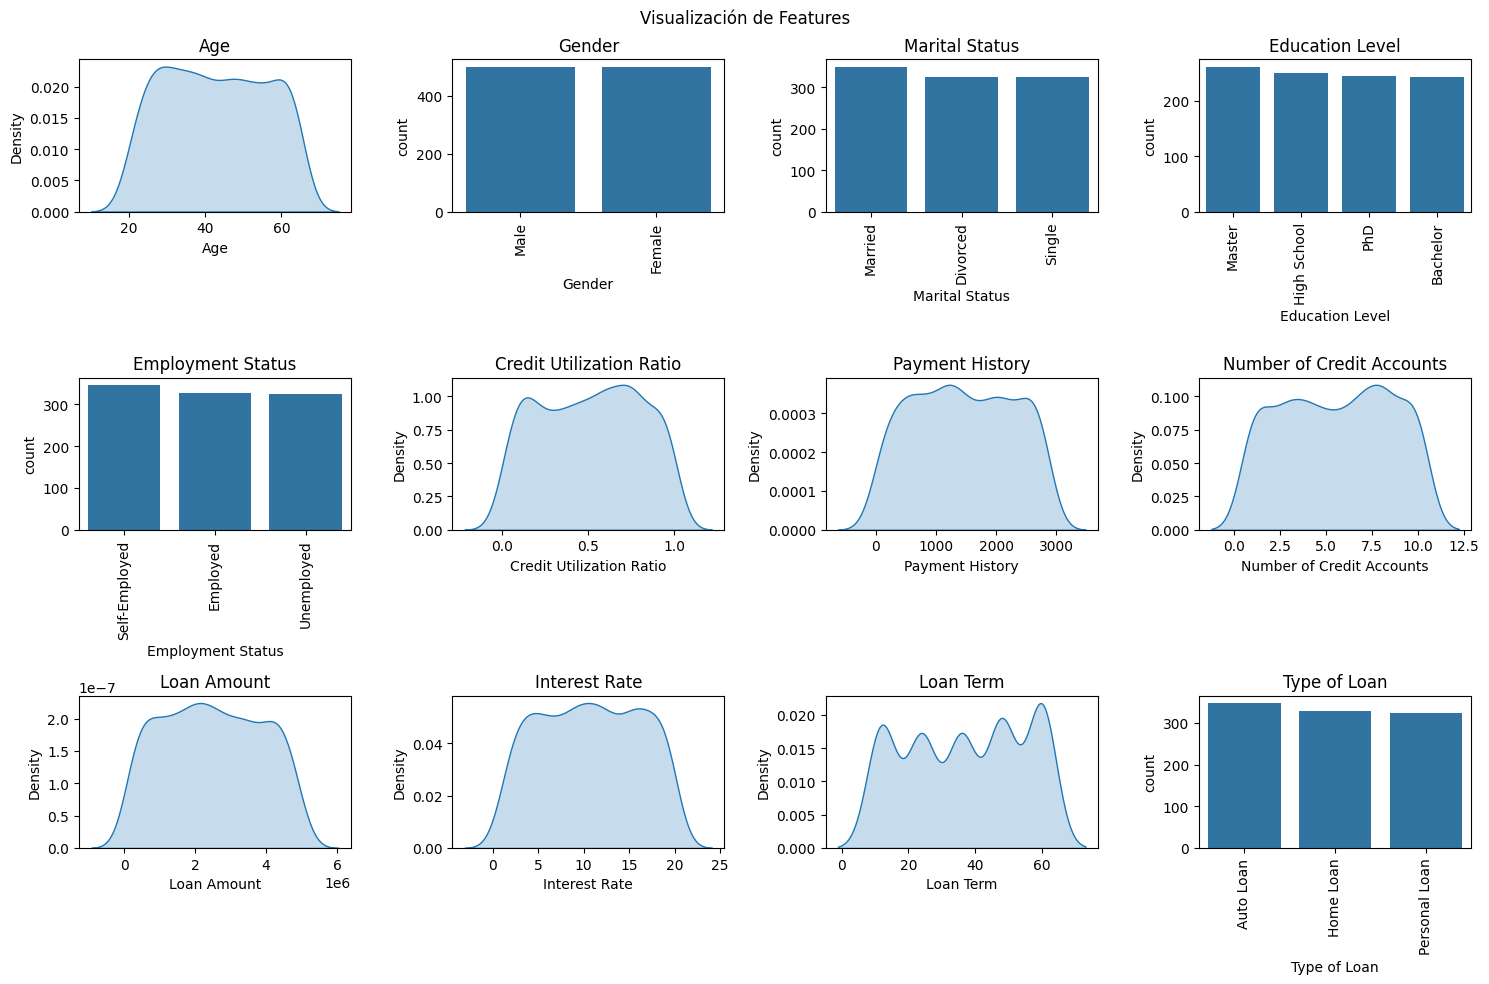

In [5]:
r, c = 3, 4
cols = list(df.columns)
v_num = df.select_dtypes(include='number').columns.to_list()

fig, axes = plt.subplots(r, c, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    if col in v_num:
        sns.kdeplot(df[col].dropna(), ax=ax, fill=True)
        ax.grid(False)
    else:
        sns.countplot(data=df, x=col, ax=ax, order=df[col].value_counts().index)
        ax.tick_params(axis='x', rotation=90)
    ax.set_title(col)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.suptitle("Visualización de Features")
plt.tight_layout()
plt.show()

# **3. Transformación de Variables**

Recordemos la estructura publicada por Fair Isaac Corporation:

$$
\text{FICO\_Score} =
300 + 550\,
\big(
0.35\,\text{PH} +
0.30\,\text{CU} +
0.15\,\text{LCH} +
0.10\,\text{NC} +
0.10\,\text{CM}
\big)
$$

In [15]:
# 1. Payment History: Asumimos un score más alto es mejor, es decir, pagos más bajos son peor.
scaler_PH = MinMaxScaler()
df["PH_score"] = 1 - scaler_PH.fit_transform(df[["Payment History"]])

# 2. Amounts Owed: Un score más alto se asocia a un porcentaje de uso menor (Credit Utilization Ratio).
df["CU_score"] = 1 - df["Credit Utilization Ratio"]

# 3. Length of Credit History: Antiguedad más alta suele dar mayor seguridad (Age) pero créditos con mayor plazo suelen ser implicar más riesgo
scaler_LT = MinMaxScaler()
df["LT_score"] = 1 - scaler_LT.fit_transform(df[["Loan Term"]])

scaler_Age = MinMaxScaler()
df["Age_score"] = scaler_Age.fit_transform(df[["Age"]])

df["LCH_score"] = 0.6 * df["LT_score"] + 0.4 * df["Age_score"]

# 4. New Credit: Más interés es más riesgoso, al igual que mayor monto de préstamo
scaler_i = MinMaxScaler()
df["i_score"] = 1 - scaler_i.fit_transform(df[["Interest Rate"]])
df["ln_LA"] = np.log(df["Loan Amount"])

scaler_LA = MinMaxScaler()
df["LA_score"] = 1 - scaler_LA.fit_transform(df[["ln_LA"]])

df["NC_score"] = 0.5 * df["LA_score"] + 0.5 * df["i_score"]

# 5. Credit Mix: Muchas cuentas puede estar asociada a mayor riesgo, por lo tanto, peor score
scaler_CM = MinMaxScaler()
df["CM_score"] = 1 - scaler_CM.fit_transform(df[["Number of Credit Accounts"]])

In [16]:
df["FOCI_raw"] = (
    0.35 * df["PH_score"] +
    0.30 * df["CU_score"] +
    0.15 * df["LCH_score"] +
    0.10 * df["NC_score"] +
    0.10 * df["CM_score"]
)

df["FOCI_score"] = 300 + 550 * df["FOCI_raw"]

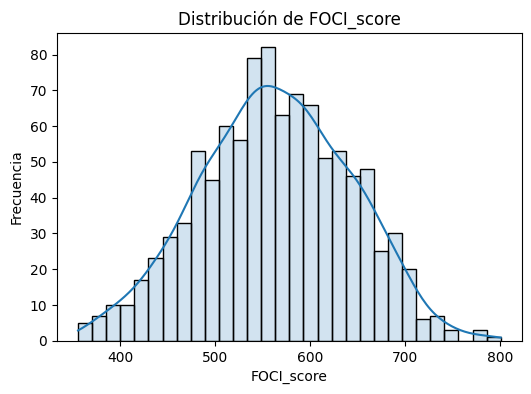

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(df["FOCI_score"].dropna(), bins=30, kde=True, alpha=0.2)
plt.title("Distribución de FOCI_score")
plt.xlabel("FOCI_score")
plt.ylabel("Frecuencia")
plt.grid(False)
plt.show()

### 📌 **TARGET a partir del FOCI_score**
Como no tienes default observado, podemos construir un proxy de riesgo usando tu FOCI_score. En la literatura de credit scoring (estilo FICO / bureau score):
- Scores bajos → mayor probabilidad de default
- Scores altos → menor probabilidad

Cuando no hay default real, se suele usar:
- Bottom 30% = Bad (1)
- Top 70% = Good (0)

In [18]:
threshold = df["FOCI_score"].quantile(0.30)

df["target"] = np.where(df["FOCI_score"] <= threshold, 1, 0)

# **4. Marco Matemático del WOE**

## **4.1  Fundamento Matemático del WOE**

Queremos entender qué mide el WOE.

Definimos el odds:

$$
Odds(x) = \frac{P(Y=1 \mid x)}{P(Y=0 \mid x)}
$$

Aplicando Bayes:

$$
\frac{P(Y=1 \mid x)}{P(Y=0 \mid x)}
=
\frac{P(x \mid Y=1)}{P(x \mid Y=0)}
\cdot
\frac{P(Y=1)}{P(Y=0)}
$$

Tomando logaritmo:

$$
\log(Odds(x))
=
\log \left(\frac{P(x \mid Y=1)}{P(x \mid Y=0)}\right)
+
\log\left(\frac{P(Y=1)}{P(Y=0)}\right)
$$

El primer término depende del segmento de la variable.

Ese término es el WOE:

$$
WOE_i =
\ln \left( \frac{P(Bin_i \mid Good)}{P(Bin_i \mid Bad)} \right)
$$


### **Interpretación**
WOE mide la evidencia relativa de ser Good vs Bad en un segmento. Es decir, el WOE mide qué tan diferente es la proporción de buenos y malos en cada categoría de una variable.

- WOE > 0: esa categoría tiene más buenos que el promedio → menor riesgo.
- WOE < 0: esa categoría tiene más malos que el promedio → mayor riesgo.
- |WOE| grande → fuerte separación.

Es una forma de transformar categorías en números que un modelo puede entender, manteniendo la lógica.

In [19]:
def calculate_woe(df, feature, target, bins=5):
    df_temp = df[[feature, target]].copy()
    
    if pd.api.types.is_numeric_dtype(df_temp[feature]):
        df_temp[feature] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
    
    grouped = df_temp.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    grouped['bad_dist'] = grouped['bad'] / grouped['bad'].sum()
    grouped['good_dist'] = grouped['good'] / grouped['good'].sum()
    
    grouped['WOE'] = np.log(grouped['good_dist'] / grouped['bad_dist'])
    
    return grouped[['total','good','bad','WOE']]

In [20]:
woe_PH_score = calculate_woe(df, "PH_score", "target")
print(woe_PH_score)

                 total  good  bad     WOE
PH_score                                 
(-0.001, 0.188]    200    62  138 -1.6474
(0.188, 0.4]       211   114   97 -0.6858
(0.4, 0.59]        195   147   48  0.2719
(0.59, 0.79]       195   179   16  1.5675
(0.79, 1.0]        199   198    1  4.4410


In [21]:
woe_PH = calculate_woe(df, "Payment History", "target")
print(woe_PH)

                  total  good  bad     WOE
Payment History                           
(-0.001, 600.0]     209   208    1  4.4902
(600.0, 1171.0]     196   178   18  1.4441
(1171.0, 1714.0]    198   146   52  0.1851
(1714.0, 2319.6]    197   106   91 -0.6947
(2319.6, 2857.0]    200    62  138 -1.6474


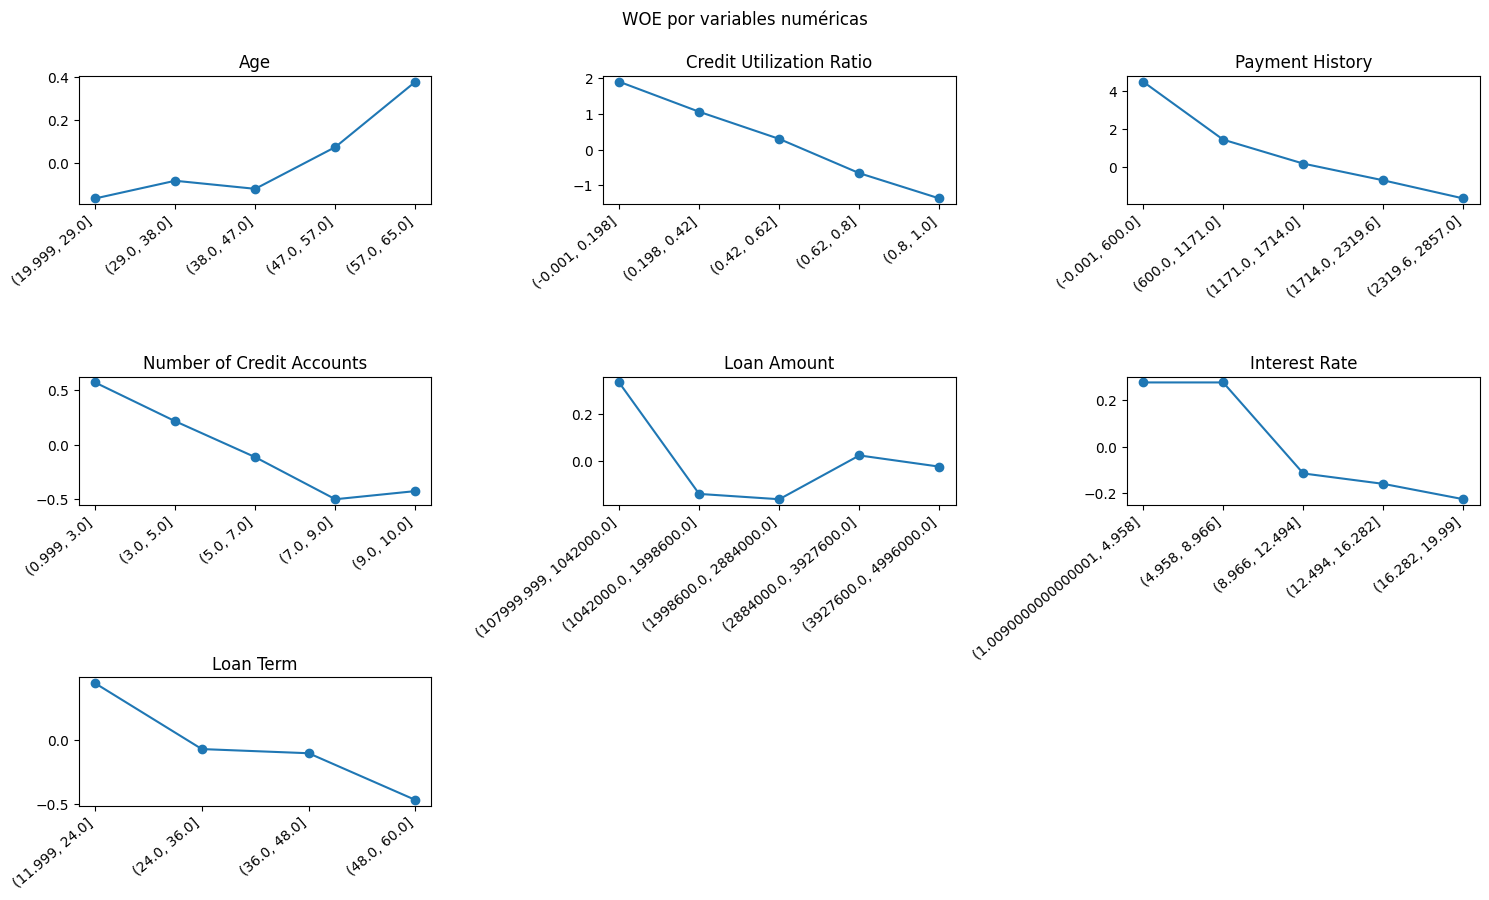

In [22]:
woe_dict = {col: calculate_woe(df, col, "target") for col in v_num}

n = len(woe_dict)
cols = 3                            
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
axes = axes.flatten()

for ax, (col, woe_df) in zip(axes, woe_dict.items()):
    ax.plot(woe_df.index.astype(str), woe_df["WOE"], marker="o")
    ax.set_title(col)
    ax.set_xticklabels(woe_df.index.astype(str), rotation=40, ha='right')
    ax.grid(False)

for ax in axes[n:]:
    ax.set_visible(False)

fig.suptitle("WOE por variables numéricas", y=0.995, fontsize=12)
fig.tight_layout()
plt.show()

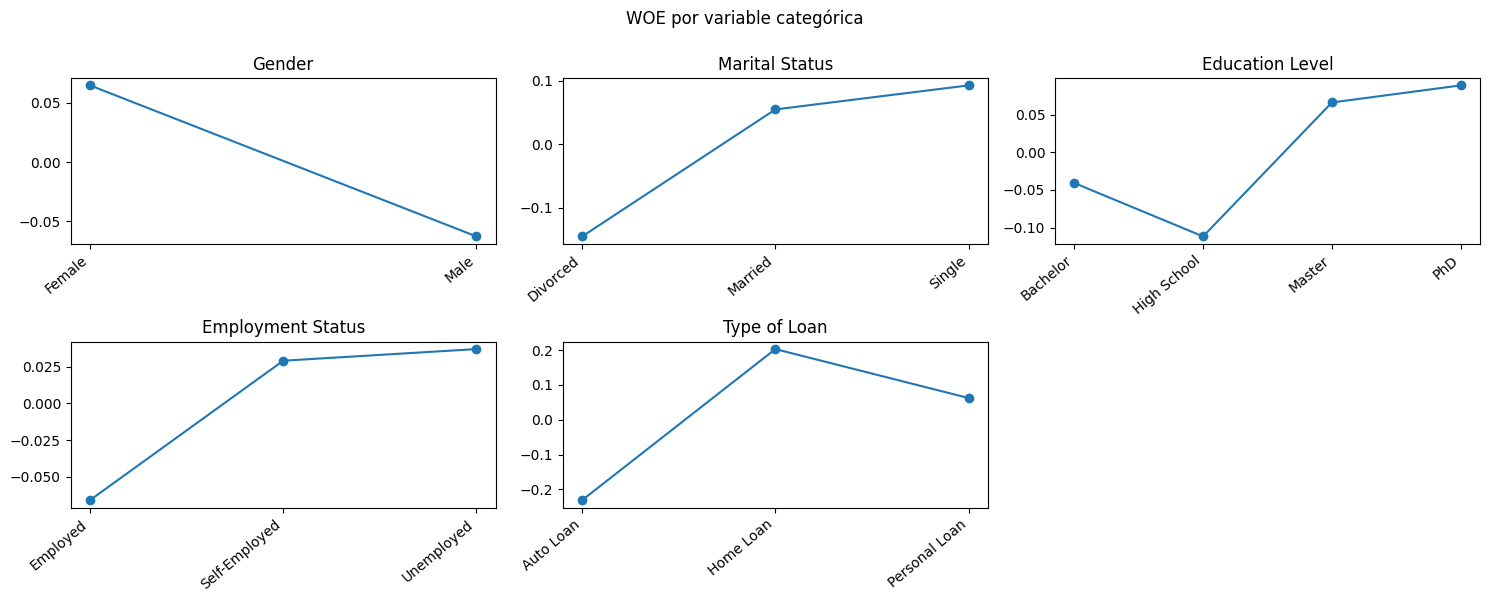

In [23]:
v_cat = df.select_dtypes(include='object').columns.to_list()
woe_dict = {col: calculate_woe(df, col, "target") for col in v_cat}

n = len(woe_dict)
cols = 3                            
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
axes = axes.flatten()

for ax, (col, woe_df) in zip(axes, woe_dict.items()):
    ax.plot(woe_df.index.astype(str), woe_df["WOE"], marker="o")
    ax.set_title(col)
    ax.set_xticklabels(woe_df.index.astype(str), rotation=40, ha='right')
    ax.grid(False)

for ax in axes[n:]:
    ax.set_visible(False)

fig.suptitle("WOE por variable categórica", y=0.995, fontsize=12)
fig.tight_layout()
plt.show()



## **Information Value (IV)**

$$
IV = \sum_i (G_i - B_i) \cdot WOE_i
$$

### **Interpretación**:

El IV mide cuánta capacidad tiene una variable para separar a los buenos de los malos.

Guía práctica bancaria:

| IV | Interpretación |
|----|---------------|
| < 0.02 | No predictiva |
| 0.02 – 0.1 | Débil |
| 0.1 – 0.3 | Media |
| 0.3 – 0.5 | Fuerte |
| > 0.5 | Sospechosa |

In [24]:
def calculate_iv(df, feature, target, bins=5):
    
    df_temp = df[[feature, target]].copy()
    
    if pd.api.types.is_numeric_dtype(df_temp[feature]):
        df_temp[feature] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
    
    grouped = df_temp.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    grouped['bad_dist'] = grouped['bad'] / grouped['bad'].sum()
    grouped['good_dist'] = grouped['good'] / grouped['good'].sum()

    grouped['WOE'] = np.log(grouped['good_dist'] / grouped['bad_dist'])
    grouped['IV'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['WOE']
    
    iv_total = grouped['IV'].sum()
    
    return iv_total

In [26]:
print("PH_score IV:", calculate_iv(df, "PH_score", "target"))

PH_score IV: 2.2941393332136606


⚠️ **Advertencia Técnica Importante**

Como estamos creando el target desde el FOCI_score y luego quieres validar variables que probablemente contribuyen al FOC existe riesgo de:
- Endogeneidad
- Circularidad
- IV artificialmente alto

Eso es normal en ejercicios académicos, pero en práctica real usarías default observado.

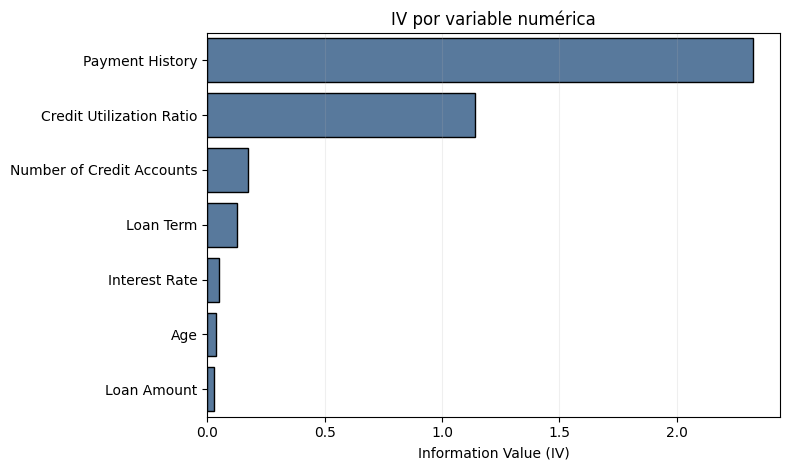

In [28]:
iv_list = []
for col in v_num:
    iv_val = calculate_iv(df, col, "target", bins=5)
    iv_list.append({"variable": col, "IV": iv_val})

iv_df = pd.DataFrame(iv_list).sort_values("IV", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 0.4*len(iv_df) + 2))
sns.barplot(data=iv_df, y="variable", x="IV", color="#4c78a8", edgecolor="black")
plt.title("IV por variable numérica")
plt.xlabel("Information Value (IV)")
plt.ylabel("")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

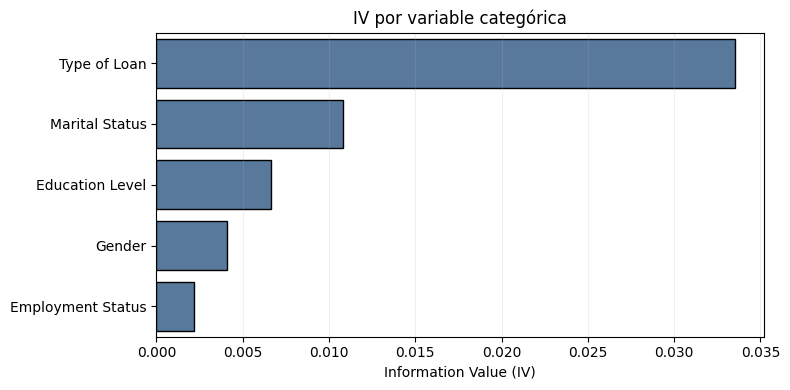

In [27]:
iv_list = []
for col in v_cat:
    iv_val = calculate_iv(df, col, "target", bins=5)
    iv_list.append({"variable": col, "IV": iv_val})

iv_df = pd.DataFrame(iv_list).sort_values("IV", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 0.4*len(iv_df) + 2))
sns.barplot(data=iv_df, y="variable", x="IV", color="#4c78a8", edgecolor="black")
plt.title("IV por variable categórica")
plt.xlabel("Information Value (IV)")
plt.ylabel("")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

## **Resumen**
1. El WOE nos dice "quién es mejor o peor".
2. El IV nos dice "qué variable sirve más para diferenciar buenos de malos".

WOE no es una simple transformación matemática.

Es una forma estructurada de:

- Introducir evidencia estadística.
- Mejorar estabilidad del modelo.
- Mantener interpretabilidad económica.
- Cumplir estándares regulatorios.

Transformar antes de modelar no es opcional en banca.
Es una práctica profesional.